In [2]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import tqdm
from pyspark.sql.window import Window
from sklearn.preprocessing import LabelEncoder

In [3]:
dask_df = dd.read_csv("../dataset/HI-Small_Trans.csv")
dask_df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


# Proportion Laundering and not Laundering

In [4]:
not_laundering = (dask_df['Is Laundering'] == 0).sum().compute()
laundering = (dask_df['Is Laundering'] == 1).sum().compute()
print(f"Total transactions: {not_laundering + laundering}")
print(f"Not laundering transactions: {not_laundering}")
print(f"Laundering transactions: {laundering}")

Total transactions: 5078345
Not laundering transactions: 5073168
Laundering transactions: 5177


# Display payment format in relation to laundering transaction

Is Laundering           0       1
Payment Format                   
ACH              596314.0  4483.0
Bitcoin          146035.0    56.0
Cash             490783.0   108.0
Cheque          1864007.0   324.0
Credit Card     1323118.0   206.0
Reinvestment     481056.0     NaN
Wire             171855.0     NaN


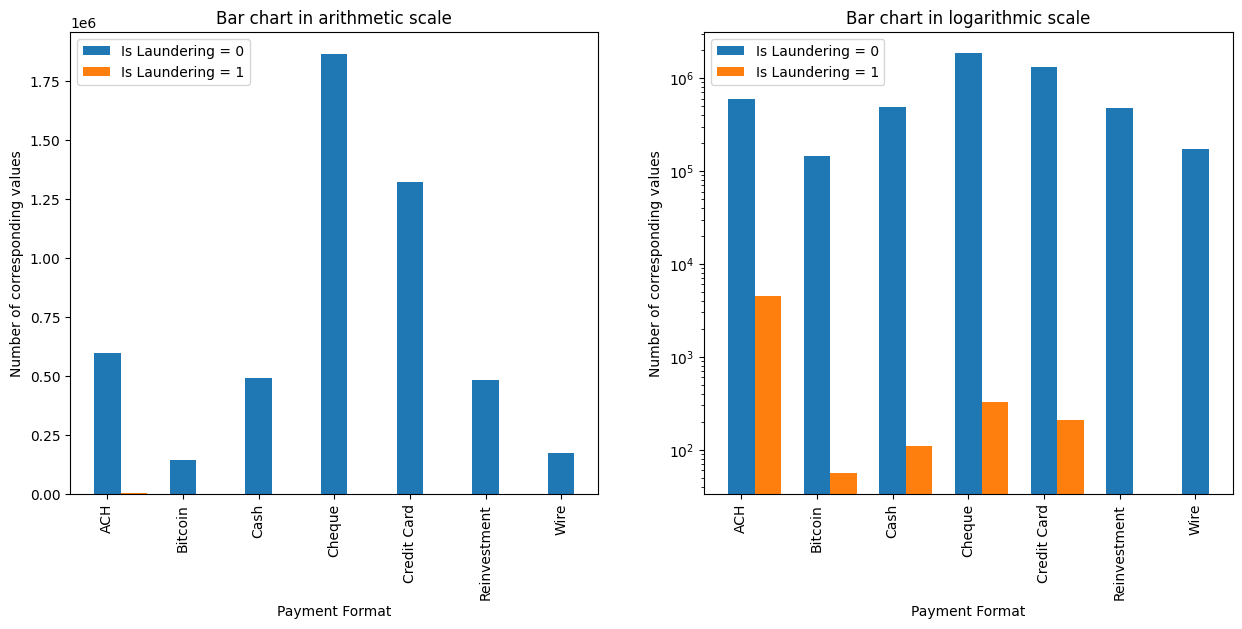

In [5]:
import matplotlib.pyplot as plt

# Calculate the number of corresponding values for each value of the "Payment Format" and "Is Laundering" columns
count_values = dask_df.groupby(['Payment Format', 'Is Laundering']).size().compute()

# Convert the results to a Pandas DataFrame and use the unstack() method
count_values_payment = count_values.unstack()

print(count_values_payment)

# Create a bar chart with a logarithmic scale
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
bar_width = 0.35
bar_positions = range(len(count_values_payment.index))
axs[0].bar(bar_positions, count_values_payment[0], bar_width, label='Is Laundering = 0')
axs[0].bar([p + bar_width for p in bar_positions], count_values_payment[1], bar_width, label='Is Laundering = 1')
axs[0].set_xticks(bar_positions)
axs[0].set_xticklabels(count_values_payment.index, rotation='vertical') 
axs[0].set_xticklabels(count_values_payment.index)
axs[0].set_xlabel('Payment Format')
axs[0].set_ylabel('Number of corresponding values')
axs[0].set_title('Bar chart in arithmetic scale')
axs[0].legend()

axs[1].bar(bar_positions, count_values_payment[0], bar_width, label='Is Laundering = 0')
axs[1].bar([p + bar_width for p in bar_positions], count_values_payment[1], bar_width, label='Is Laundering = 1')
axs[1].set_xticks(bar_positions)
axs[1].set_xticklabels(count_values_payment.index, rotation='vertical') 
axs[1].set_xticklabels(count_values_payment.index)
axs[1].set_xlabel('Payment Format')
axs[1].set_ylabel('Number of corresponding values')
axs[1].set_title('Bar chart in logarithmic scale')
axs[1].legend()
axs[1].set_yscale('log')

# Show the chart
plt.show()

# Display payment currency in relation to laundering transaction

Is Laundering            0     1
Payment Currency                
US Dollar          1893260  1912
Euro               1166925  1372
Saudi Riyal          88640   374
Swiss Franc         234667   193
Yuan                213568   184
Rupee               190035   167
Yen                 155054   155
Ruble               155045   133
UK Pound            180606   132
Canadian Dollar     139914   128
Australian Dollar   136642   127
Shekel              192089    95
Mexican Peso        110067    92
Brazil Real          70646    57
Bitcoin             146010    56


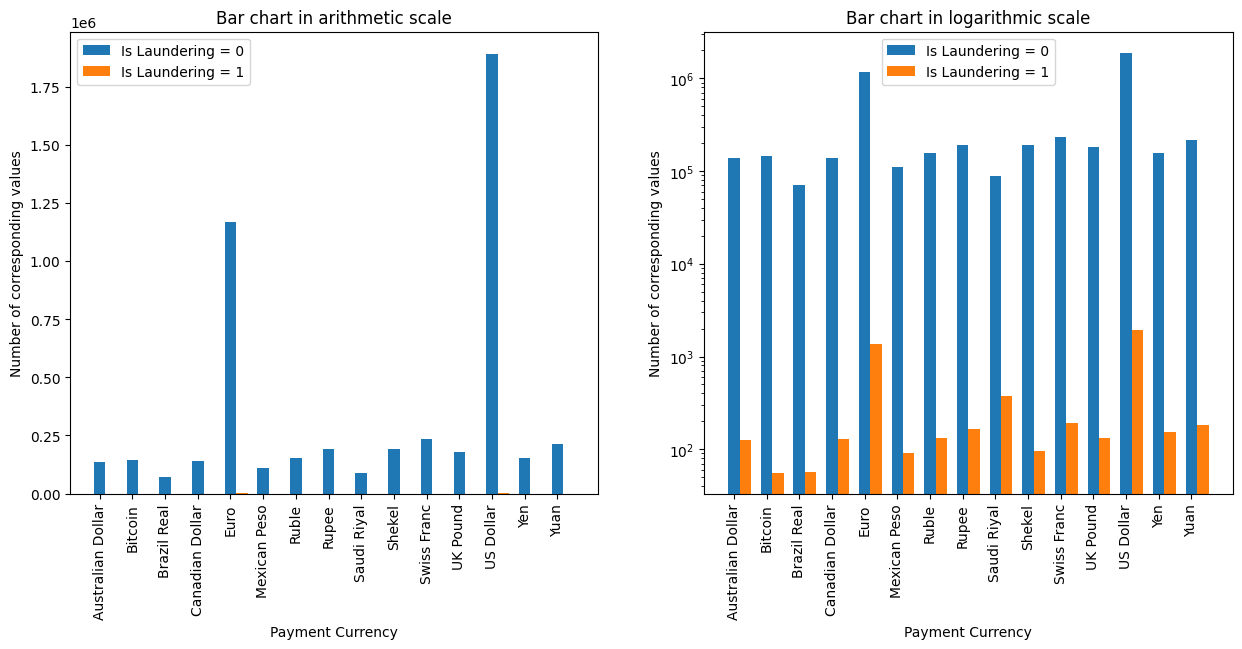

In [6]:
# Calculate the number of corresponding values for each value of the "Payment Format" and "Is Laundering" columns
count_values = dask_df.groupby(['Payment Currency', 'Is Laundering']).size().compute()

# Convert the results to a Pandas DataFrame and use the unstack() method
count_values = count_values.unstack()

print(count_values.sort_values(1, ascending=False))

# Create a bar chart with a logarithmic scale
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
bar_width = 0.35
bar_positions = range(len(count_values.index))
axs[0].bar(bar_positions, count_values[0], bar_width, label='Is Laundering = 0')
axs[0].bar([p + bar_width for p in bar_positions], count_values[1], bar_width, label='Is Laundering = 1')
axs[0].set_xticks(bar_positions)
axs[0].set_xticklabels(count_values.index, rotation='vertical') 
axs[0].set_xticklabels(count_values.index)
axs[0].set_xlabel('Payment Currency')
axs[0].set_ylabel('Number of corresponding values')
axs[0].set_title('Bar chart in arithmetic scale')
axs[0].legend()

axs[1].bar(bar_positions, count_values[0], bar_width, label='Is Laundering = 0')
axs[1].bar([p + bar_width for p in bar_positions], count_values[1], bar_width, label='Is Laundering = 1')
axs[1].set_xticks(bar_positions)
axs[1].set_xticklabels(count_values.index, rotation='vertical') 
axs[1].set_xticklabels(count_values.index)
axs[1].set_xlabel('Payment Currency')
axs[1].set_ylabel('Number of corresponding values')
axs[1].set_title('Bar chart in logarithmic scale')
axs[1].legend()
axs[1].set_yscale('log')

# Show the chart
plt.show()

# Display top 10 accounts for fraudolent transactions

In [7]:
account_df = dask_df.groupby('Account')['Is Laundering'].sum().reset_index()
account1_df = dask_df.groupby('Account.1')['Is Laundering'].sum().reset_index()
merged_df = account_df.merge(account1_df, left_on='Account', right_on='Account.1')

# somma i valori di Is Laundering
merged_df['Is Laundering'] = merged_df['Is Laundering_x'] + merged_df['Is Laundering_y']

# seleziona solo le colonne necessarie
merged_df = merged_df[['Account', 'Is Laundering']]
merged_df = merged_df.sort_values('Is Laundering', ascending=False)
merged_df.head(10)

,Account,Is Laundering
0,100428660,243
1,1004286A8,158
287831,811C599A0,52
41703,80266F880,51
36190,8021353D0,49
287830,811C597B0,44
303658,812D22980,38
300692,812A09CF0,35
286974,811B83280,34
300693,812A09D40,33


# Label Encoding values

In [8]:
# Conversione della colonna 'date' in oggetti datetime
dask_df['Timestamp'] = dd.to_datetime(dask_df['Timestamp'], format='%Y/%m/%d %H:%M')
# Conversione degli oggetti datetime in numeri float rappresentanti la data
dask_df['Timestamp'] = dask_df['Timestamp'].dt.strftime('%Y%m%d%H%M').astype(int)

df = dask_df.compute()


In [9]:
le = LabelEncoder()
le.fit(list(set(df['Account']).union(set(df['Account.1']))))
df[['Account', 'Account.1']] = df[['Account', 'Account.1']].apply(le.transform)
le.fit(list(set(df['Receiving Currency']).union(set(df['Payment Currency']))))
df[['Receiving Currency', 'Payment Currency']] = df[['Receiving Currency', 'Payment Currency']].apply(le.transform)
df[['Payment Format']] = df[['Payment Format']].apply(le.fit_transform)

In [10]:
df.head(5)

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,202209010020,10,942,10,942,3697.34,12,3697.34,12,5,0
1,202209010020,3208,991,1,1002,0.01,12,0.01,12,3,0
2,202209010000,3209,992,3209,992,14675.57,12,14675.57,12,5,0
3,202209010002,12,998,12,998,2806.97,12,2806.97,12,5,0
4,202209010006,10,1000,10,1000,36682.97,12,36682.97,12,5,0


# Display correlation matrix for fraudolent transactions

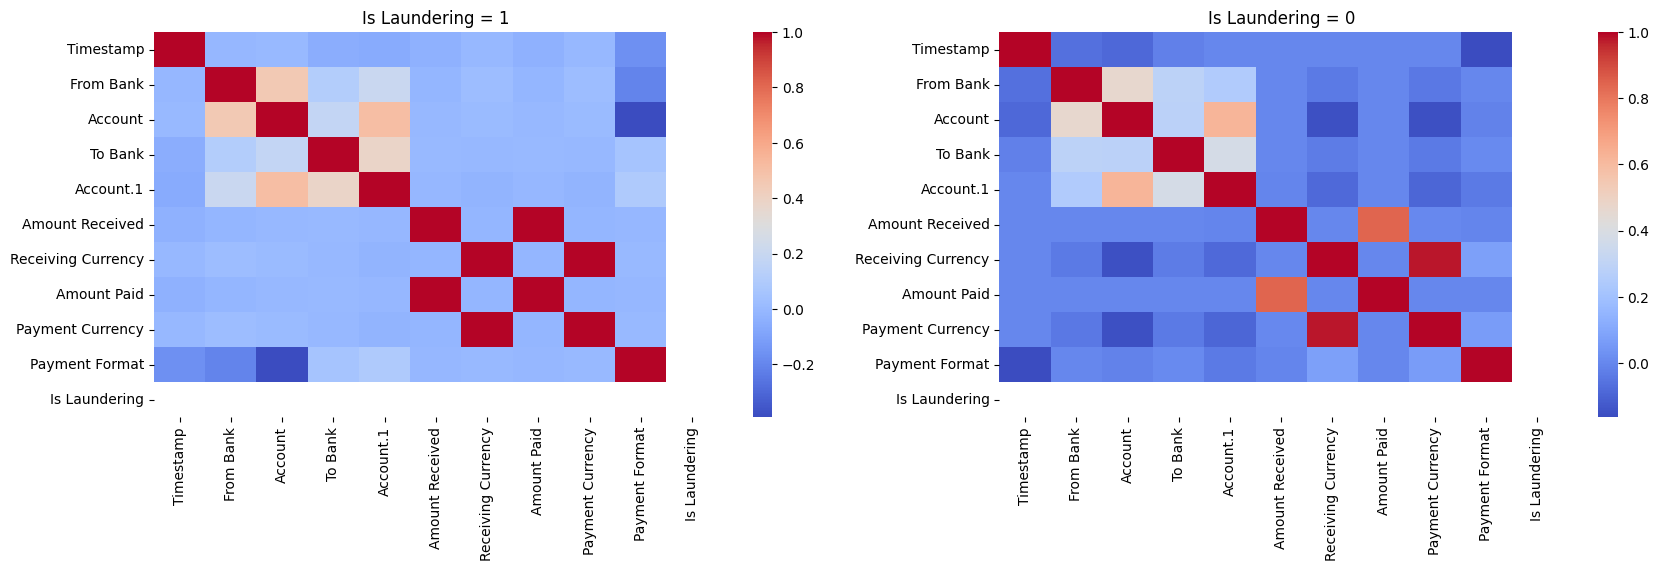

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

cm_laundering = df[df['Is Laundering'] == 1].corr()
cm_not_laundering = df[df['Is Laundering'] == 0].corr()

# create subplots
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))

# plot the first correlation matrix heatmap
sns.heatmap(cm_laundering, cmap='coolwarm', annot=False, ax=axs[0])
axs[0].set_title('Is Laundering = 1')

# plot the second correlation matrix heatmap
sns.heatmap(cm_not_laundering, cmap='coolwarm', annot=False, ax=axs[1])
axs[1].set_title('Is Laundering = 0')

# display the plot
plt.show()


In [12]:
print("Laundering:")
count_amount, count_currency = len(df[(df['Amount Received'] == df['Amount Paid']) & (df['Is Laundering'] == 1)]), len(df[(df['Receiving Currency'] == df['Payment Currency']) & (df['Is Laundering'] == 1)])
print(f"    Same amount: {count_amount}")
print(f"    Same currency: {count_currency}")
print(f"    Difference: {np.abs(count_amount - count_currency)}\n")

count_amount, count_currency = len(df[(df['Amount Received'] != df['Amount Paid']) & (df['Is Laundering'] == 1)]), len(df[(df['Receiving Currency'] != df['Payment Currency']) & (df['Is Laundering'] == 1)])
print(f"    Different amount: {count_amount}")
print(f"    Different currency: {count_currency}")
print(f"    Difference: {np.abs(count_amount - count_currency)}\n")

print("Not Laundering:")
count_amount, count_currency = len(df[(df['Amount Received'] == df['Amount Paid']) & (df['Is Laundering'] == 0)]), len(df[(df['Receiving Currency'] == df['Payment Currency']) & (df['Is Laundering'] == 0)])
print(f"    Same amount: {count_amount}")
print(f"    Same currency: {count_currency}")
print(f"    Difference: {np.abs(count_amount - count_currency)}\n")

count_amount, count_currency = len(df[(df['Amount Received'] != df['Amount Paid']) & (df['Is Laundering'] == 0)]), len(df[(df['Receiving Currency'] != df['Payment Currency']) & (df['Is Laundering'] == 0)])
print(f"    Different amount: {count_amount}")
print(f"    Different currency: {count_currency}")
print(f"    Difference: {np.abs(count_amount - count_currency)}")

Laundering:
    Same amount: 5177
    Same currency: 5177
    Difference: 0

    Different amount: 0
    Different currency: 0
    Difference: 0

Not Laundering:
    Same amount: 5001010
    Same currency: 5000998
    Difference: 12

    Different amount: 72158
    Different currency: 72170
    Difference: 12


# More correlation among Accounts

Find how many times an Account send laund money and not laund money to the same Account.1

In [13]:
df_temp = df[['Account', 'Account.1', 'Is Laundering']]
df_grouped = df_temp.groupby(['Account', 'Account.1'])['Is Laundering'].nunique().reset_index()
df_grouped[df_grouped['Is Laundering'] > 1].groupby('Account').count().reset_index().rename(columns={'Is Laundering': 'times'}).drop('Account.1', axis=1).sort_values(by='times', ascending=False).head(10)


,Account,times
0,0,236
1,1,156
11,11,28
6,6,26
3,3,22
2,2,21
4,4,21
14,14,18
5,5,16
8,8,16


Find all transactions that are send from A to B with a certain value and from B to C with the same value.

For this it is necessary to use something like graphframes

In [14]:
import sys
sys.path.append("/Users/fabio/jars")

In [32]:
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext
from graphframes import GraphFrame
from pyspark.sql.types import *

spark_driver_memory = "10g"
spark_executor_memory = "6g"



spark = SparkSession.builder \
                    .config("spark.driver.memory", spark_driver_memory) \
                    .config("spark.executor.memory", spark_executor_memory) \
                    .master("local[*]") \
                    .getOrCreate()
spark.sparkContext.setLogLevel('WARN')
print("Spark session created")
sc = spark.sparkContext
print("Spark context created")

Spark session created
Spark context created


In [16]:
schema = StructType([
    StructField('timestamp', FloatType(), True),
    StructField('from_bank', IntegerType(), True),
    StructField('from_account', IntegerType(), True),
    StructField('to_bank', IntegerType(), True),
    StructField('to_account', IntegerType(), True),
    StructField('amount_received', FloatType(), True),
    StructField('receiving_currency', IntegerType(), True),
    StructField('amount_paid', FloatType(), True),
    StructField('payment_currency', IntegerType(), True),
    StructField('payment_format', IntegerType(), True),
    StructField('is_laundering', IntegerType(), True)])


In [62]:
df = df.rename(columns={'Timestamp': 'timestamp', 'From Bank': 'from_bank', 'Account': 'account1',
                           'To Bank': 'to_bank', 'Account.1': 'account2', 'Amount Received': 'amount_received',
                             'Receiving Currency': 'receiving_currency', 'Amount Paid': 'amount_paid', 'Payment Currency': 'payment_currency',
                               'Payment Format': 'payment_format', 'Is Laundering': 'is_laundering'})
df.to_parquet('df.parquet')

In [17]:
spark_df = spark.read.parquet('df.parquet').drop("__index_level_0__").withColumn("index", monotonically_increasing_id())
spark_df.show(5)

+------------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+-----------+
|   timestamp|from_bank|account1|to_bank|account2|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|      index|
+------------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+-----------+
|202209010020|       10|     942|     10|     942|        3697.34|                12|    3697.34|              12|             5|            0|42949672960|
|202209010020|     3208|     991|      1|    1002|           0.01|                12|       0.01|              12|             3|            0|42949672961|
|202209010000|     3209|     992|   3209|     992|       14675.57|                12|   14675.57|              12|             5|            0|42949672962|
|202209010002|       12|     998|     12|     998|        2806.9

In [18]:
verteces = spark_df.select(col("account1").alias("id")).union(spark_df.select(col("account2").alias("id"))).distinct()
edges = spark_df.select(col("account1").alias("src"), col("account2").alias("dst"), col("index"), col("amount_paid").alias("amount"), col("timestamp"), col("payment_format"), col("is_laundering"))
g = GraphFrame(verteces, edges)

In [19]:
pattern = g.find("(a)-[c1]->(b); (b)-[c2]->(c) ").filter("""
                                              a != b and
                                              b != c and

                                              c1.amount == c2.amount and
                                              c1.timestamp < c2.timestamp
                                            """)
pattern.show(5, truncate=False)


+--------+---------------------------------------------------+---+---------------------------------------------------+--------+
|a       |c1                                                 |b  |c2                                                 |c       |
+--------+---------------------------------------------------+---+---------------------------------------------------+--------+
|{330838}|{330838, 0, 42953919539, 26.46, 202209090046, 2, 0}|{0}|{0, 478351, 42954632597, 26.46, 202209100905, 3, 0}|{478351}|
|{330838}|{330838, 0, 42953919539, 26.46, 202209090046, 2, 0}|{0}|{0, 478351, 42954054031, 26.46, 202209090533, 3, 0}|{478351}|
|{330838}|{330838, 0, 42951485575, 26.46, 202209022203, 2, 0}|{0}|{0, 478351, 42954632597, 26.46, 202209100905, 3, 0}|{478351}|
|{330838}|{330838, 0, 42951485575, 26.46, 202209022203, 2, 0}|{0}|{0, 478351, 42954054031, 26.46, 202209090533, 3, 0}|{478351}|
|{330838}|{330838, 0, 42951485575, 26.46, 202209022203, 2, 0}|{0}|{0, 478351, 42953725908, 26.46, 202209

In [20]:
array_features =  np.array(pattern.select('c1','c2').collect(), dtype=int).squeeze()

In [21]:
from collections import defaultdict, Counter
dictionary = defaultdict(list)
for array in array_features:
    dictionary[(array[0][5], array[1][5])].append((array[0][6], array[1][6]))

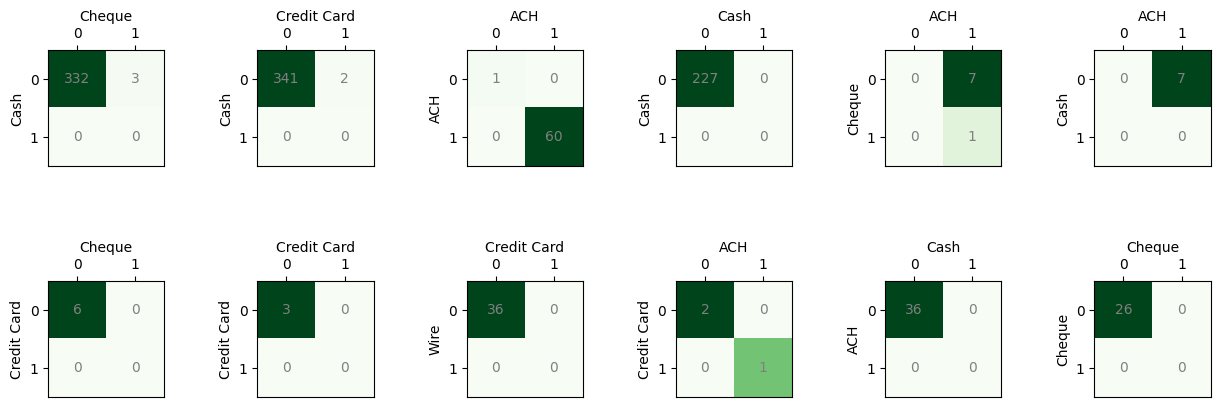

In [22]:
le = LabelEncoder()
le.fit(list(count_values_payment.reset_index()['Payment Format']))
c = Counter()
l = []
matrix = [[0 for _ in range(6)] for _ in range(7)]
data = {}
for key, items in dictionary.items():
    i = Counter(items)
    string = f"{le.inverse_transform([key[0]])[0]}-{le.inverse_transform([key[1]])[0]}"
    data[string] = np.array([[i[(0,0)], i[(0,1)]], [i[(1,0)], i[(1,1)]]])

fig, axs = plt.subplots(2, 6, figsize=(15, 5))

# Loop over each payment type and display the matrix values in the corresponding subplot
for i, (payment, matrix) in enumerate(data.items()):
    # Compute the row and column indices for the current subplot
    row = i // 6
    column = i % 6
    
    # Display the matrix values in the current subplot
    axs[row, column].imshow(matrix, cmap='Greens')
    axs[row, column].set_xticks([0, 1])
    axs[row, column].set_yticks([0, 1])
    axs[row, column].set_xticklabels(['0', '1'])
    axs[row, column].set_yticklabels(['0', '1'])
    axs[row, column].set_xlabel(str(payment.split("-")[1]))
    axs[row, column].set_ylabel(str(payment.split("-")[0]))
    axs[row, column].xaxis.set_label_position('top')
    axs[row, column].yaxis.set_label_position('left')
    axs[row, column].xaxis.set_ticks_position('top')
    axs[row, column].yaxis.set_ticks_position('left')

    for i in range(2):
        for j in range(2):
            axs[row, column].annotate(str(matrix[i, j]), xy=(j, i), ha='center', va='center', color='grey')


# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.8, hspace=0.5)

# Show the plot
plt.show()

# Find circular patterns

In [23]:
def find_cycles(g: GraphFrame, hop: int = 2):
    motif = ""

    for i in range(hop):
        motif += "(n" + str(i) + ")-[c" + str(i+1) + "]->(n" + str((i+1) % hop) + "); "
    motif = motif.strip("; ")

    filter_string = ""
    for i in range(hop):
        for j in range(i, hop-1):
            filter_string += "n{} != n{}".format(i, j+1)
            if i+1 < hop-1:
                filter_string += " and "
    filter_string += " and "
    for j in range(1,hop):
            filter_string += "c{}.timestamp < c{}.timestamp".format(j, j+1)
            if(j+1 < hop):
                filter_string += " and "    
    graph = g.find(motif)
    graph = graph.filter(filter_string)
    select_col = []
    for i in range(hop):
        select_col.append("c{}".format(i+1))
    pattern = np.array(graph.select(*select_col).collect()).squeeze()
    total_rows = []

    for row in pattern:
        if isinstance(row[1], np.ndarray):
            for r in row:
                #index | timestamp | from | to | payment_format | is_laundering | hop
                total_rows.append([int(r[2]), r[4], int(r[0]), int(r[1]), int(r[5]), int(r[6]), hop])
        else:
            total_rows.append([int(row[2]), row[4], int(row[0]), int(row[1]), int(row[5]), int(row[6]), hop])

    dataframe = pd.DataFrame(total_rows, columns=['index', 'timestamp', 'from', 'to', 'payment_format', 'is_laundering', 'hop'])

    return dataframe.drop_duplicates()

In [33]:
all_df = []
filtered_spark = spark_df.filter(col("payment_currency") == col("receiving_currency"))
filtered_spark.cache()
payment_formats = filtered_spark.select("payment_format").distinct().rdd.flatMap(lambda x: x).collect()

for j in range(1):
    verteces = filtered_spark.filter(col("payment_format") == j).select(col("account1").alias("id")).union(spark_df.select(col("account2").alias("id"))).distinct()
    edges = filtered_spark.filter(col("payment_format") == j).select(col("account1").alias("src"), col("account2").alias("dst"), col("index"), col("amount_paid").alias("amount"), col("timestamp"), col("payment_format"), col("is_laundering"))
    g = GraphFrame(verteces, edges)
    g = g.dropIsolatedVertices()
    for i in tqdm.tqdm(range(2,14)):
        all_df.append(find_cycles(g, i))

100%|██████████| 12/12 [02:11<00:00, 10.96s/it]                                 


In [34]:
merged_df = pd.concat(all_df, ignore_index=True)

# Step 4: Applica il one-hot encoding sulla colonna "hop"
one_hot_encoded_df = pd.get_dummies(merged_df, columns=['hop'], prefix='hop')
grouped_df = one_hot_encoded_df.groupby('index').agg({
    'timestamp': 'first',
    'from': 'first',
    'to': 'first',
    'payment_format': 'first',
    'is_laundering': 'first',
    'hop_2': 'any',
    'hop_3': 'any',
    'hop_4': 'any',
    'hop_5': 'any',
    'hop_6': 'any',
    'hop_7': 'any',
    'hop_8': 'any',
    'hop_9': 'any',
    'hop_10': 'any',
    'hop_11': 'any',
    'hop_12': 'any',
}).reset_index()
columns_to_encode = ['hop_2', 'hop_3', 'hop_4', 'hop_5', 'hop_6', 'hop_7', 'hop_8', 'hop_9', 'hop_10', 'hop_11', 'hop_12']
grouped_df[columns_to_encode] = grouped_df[columns_to_encode].astype(int)

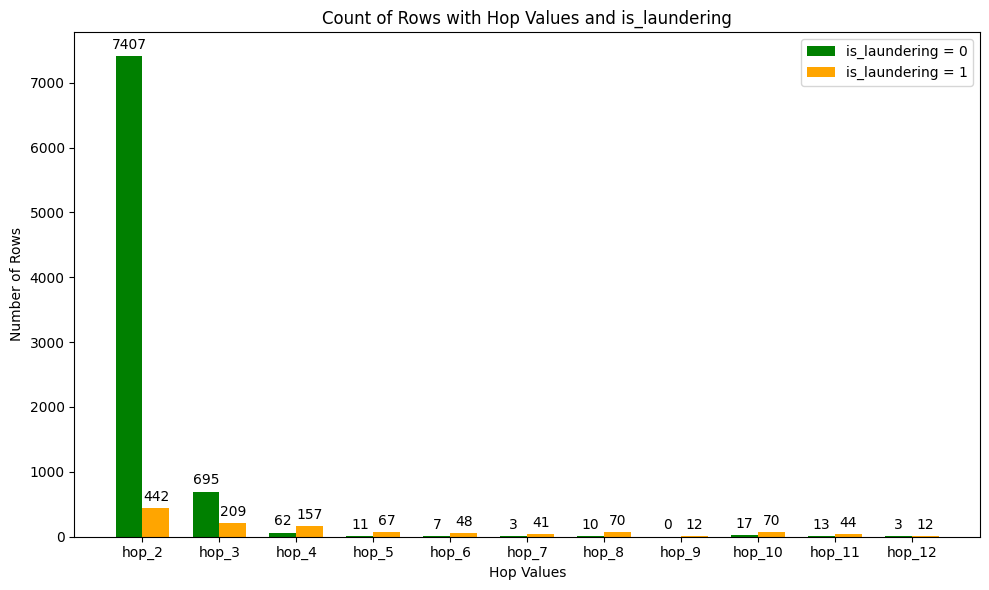

In [35]:
# Calcola il conteggio delle righe che soddisfano le condizioni specificate per ogni valore hop da hop_2 a hop_12
hop_columns = grouped_df.columns[grouped_df.columns.str.startswith('hop_')].tolist()
counts = {}
for hop_column in hop_columns:
    count_0 = grouped_df[(grouped_df[hop_column] == 1) & (grouped_df['is_laundering'] == 0)].shape[0]
    count_1 = grouped_df[(grouped_df[hop_column] == 1) & (grouped_df['is_laundering'] == 1)].shape[0]
    counts[hop_column] = {'0': count_0, '1': count_1}

# Converti i risultati in un DataFrame
counts_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
counts_df = counts_df.rename(columns={'index': 'hop'})

color_0 = 'green'
color_1 = 'orange'

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
x = counts_df.index
labels = counts_df['hop']
bar_0 = ax.bar(x - width / 2, counts_df['0'], width,  label='is_laundering = 0', color=color_0)
bar_1 = ax.bar(x + width / 2, counts_df['1'], width,  label='is_laundering = 1', color=color_1)

ax.set_xlabel('Hop Values')
ax.set_ylabel('Number of Rows')
ax.set_title('Count of Rows with Hop Values and is_laundering')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add count labels above each bar
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(bar_0)
autolabel(bar_1)

plt.tight_layout()
plt.show()

# Find Fan In 

In [36]:
def find_fanin(g: GraphFrame):
    motif = "(a)-[c1]->(b); (c)-[c2]->(b)"
    filter_motif = "(abs(c1.timestamp - c2.timestamp)) <= 40000 and c1.index != c2.index and c1.payment_currency == c2.payment_currency"#and c1.payment_format == c2.payment_format"
  
    pattern = g.find(motif).filter(filter_motif).select("c1", "c2").distinct()
    fan_in_trans = pattern.groupBy(col("c1")).agg(count("*").alias("fan_in_degree")).select(col("c1").alias("transaction"), col("fan_in_degree"))
    fan_in_trans.cache()
    
    
        
    return fan_in_trans

In [37]:
filtered_spark = spark_df.filter(col("payment_currency") == col("receiving_currency"))
filtered_spark.cache()
payment_formats = filtered_spark.select("payment_format").distinct().rdd.flatMap(lambda x: x).collect()

total_fan_in = None

for payment_format in payment_formats:
    print(f"Find fan in payment_format: {payment_format}")
    filtered_by_format = filtered_spark.filter(col("payment_format") == payment_format)
    verteces = (
        filtered_by_format.select(col("account1").alias("id"))
        .union(spark_df.select(col("account2").alias("id")))
        .distinct()
    )
    edges = (
        filtered_by_format.select(
            col("account1").alias("src"),
            col("account2").alias("dst"),
            col("index"),
            col("timestamp"),
            col("payment_currency"),
            col("is_laundering")
            
        )
    )
    g = GraphFrame(verteces, edges)
    if total_fan_in is None:
        total_fan_in = find_fanin(g)
    else:
        total_fan_in = total_fan_in.unionAll(find_fanin(g))

23/08/01 12:09:07 WARN CacheManager: Asked to cache already cached data.


Find fan in payment_format: 0
Find fan in payment_format: 6
Find fan in payment_format: 5
Find fan in payment_format: 1
Find fan in payment_format: 3
Find fan in payment_format: 2
Find fan in payment_format: 4


In [38]:
# Definisci la funzione UDF per estrarre i valori dalla colonna "transaction" e creare una struttura
def extract_values(transaction):
    src, dst, index, timestamp, payment_format, is_laundering = transaction
    return (src, dst, index, timestamp, payment_format, is_laundering)

# Definisci lo schema per il DataFrame Spark
schema = StructType([
    StructField("src", IntegerType(), True),
    StructField("dst", IntegerType(), True),
    StructField("index", IntegerType(), True),
    StructField("timestamp", FloatType(), True),
    StructField("payment_format", IntegerType(), True),
    StructField("is_laundering", IntegerType(), True)
])

In [ ]:
# Applica la funzione UDF per estrarre i valori dalla colonna "transaction" e crea un nuovo DataFrame
extract_udf = udf(extract_values, schema)
new_spark_df = total_fan_in.withColumn("extracted", extract_udf("transaction"))

# Seleziona le colonne necessarie e converte il DataFrame Spark in un DataFrame Pandas
pandas_df = new_spark_df.select("extracted.*", "fan_in_degree").toPandas()


In [61]:
# Create a color map for different payment_formats
num_unique_payment_formats = pandas_df['payment_format'].nunique()
color_map = plt.cm.get_cmap('tab20', num_unique_payment_formats)  # Choose 'tab20' colormap for more distinct colors

# Mapping dictionary for payment_format names
payment_format_names = {
    0: 'ACH',
    1: 'Bitcoin',
    2: 'Cash',
    3: 'Cheque',
    4: 'Credit Card',
    5: 'Reinvestment',
    6: 'Wire',
    # Add more mappings as needed
}

# Replace the payment_format values with their desired names
pandas_df['payment_format_name'] = pandas_df['payment_format'].map(payment_format_names)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points with different colors based on payment_format
for i, (payment_format, group_df) in enumerate(pandas_df.groupby('payment_format_name')):
    color = color_map(i / num_unique_payment_formats)  # Map payment_format to a color from the colormap
    ax.scatter(group_df['fan_in_degree'], group_df['is_laundering'], group_df['payment_format'],
               alpha=0.5, marker='o', color=color)

    # Add text annotation for payment_format on the vertical axis
    for j, (fan_in_degree, is_laundering, _) in enumerate(group_df[['fan_in_degree', 'is_laundering', 'payment_format']].values):
        ax.text(fan_in_degree, is_laundering, j, payment_format, color=color, fontsize=8)

# Set axis labels
ax.set_xlabel('Fan_in_degree')
ax.set_ylabel('Is_laundering')
ax.set_zlabel('Payment_format')

# Set the title
ax.set_title('Correlation between Fan_in_degree, Is_laundering, and Payment_format')

plt.show()

/tmp/ipykernel_1386964/1219193283.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_payment_formats)  # Choose 'tab20' colormap for more distinct colors


# Find fan out

In [ ]:

def find_fanout(g: GraphFrame):
    motif = "(a)-[c1]->(b); (a)-[c2]->(c)"
    filter_motif = "(abs(c1.timestamp - c2.timestamp)) <= 40000 and c1.index != c2.index"
  
    pattern = g.find(motif).filter(filter_motif).select("c1", "c2").distinct()
    fan_out_trans = pattern.groupBy(col("c1")).agg(count("*").alias("fan_out_degree")).select(col("c1").alias("transaction"), col("fan_out_degree"))
    fan_out_trans.cache()
    
    
        
    return fan_out_trans

In [ ]:
filtered_spark = spark_df.filter(col("payment_currency") == col("receiving_currency"))
filtered_spark.cache()
payment_formats = filtered_spark.select("payment_format").distinct().rdd.flatMap(lambda x: x).collect()

total_fan_out = None

for payment_format in range(2):
    print(f"Find fan in payment_format: {payment_format}")
    filtered_by_format = filtered_spark.filter(col("payment_format") == payment_format)
    verteces = (
        filtered_by_format.select(col("account1").alias("id"))
        .union(spark_df.select(col("account2").alias("id")))
        .distinct()
    )
    edges = (
        filtered_by_format.select(
            col("account1").alias("src"),
            col("account2").alias("dst"),
            col("index"),
            col("timestamp"),
            col("is_laundering")
        )
    )
    g = GraphFrame(verteces, edges)
    if total_fan_out is None:
        total_fan_out = find_fanout(g)
    else:
        total_fan_out = total_fan_out.unionAll(find_fanout(g))

In [ ]:
total_fan_out.filter(col("transaction.is_laundering") == 1).show(truncate = False)

In [ ]:
filtered_df = spark_df.filter(col("payment_format") == 0)
vertices = filtered_df.select(col("account1").alias("id")).union(spark_df.select(col("account2").alias("id"))).distinct()
edges = filtered_df.select(col("account1").alias("src"), col("account2").alias("dst"), col("index"), col("amount_paid").alias("amount"), col("timestamp"), col("payment_format"), col("is_laundering"))
g = GraphFrame(verteces, edges)
g = g.dropIsolatedVertices()
c = g.stronglyConnectedComponents(maxIter=2)

window = Window.partitionBy("component")
filter_g = c.withColumn("count", count('*').over(window)).filter("count >= 2").orderBy("count",ascending=False).select("id").distinct()
uses_df = filter_g.alias("a").join(vertices.alias("b"), col("a.id") == col("b.id"), "left").select("b.id")

vertices = uses_df
joined1 = edges.alias("a").join(vertices.alias("b"), (col("a.src") == col("b.id")), "inner").drop("id")
joined2 = joined1.alias("a").join(vertices.alias("b"), col("a.dst") == col("b.id"), "inner")
edges = joined2.drop("id")
graph = GraphFrame(vertices, edges)
graph = graph.dropIsolatedVertices()

"""in_degrees = graph.inDegrees.filter("inDegree >= 10").drop("in_degrees")
edges = edges.alias("a").join(in_degrees.alias("b"), col("a.dst") == col("b.id"), "left").select("a.*")
out_verteces = vertices.alias("a").join(vertices.alias("b"), col("a.id") == col("b.id"), "right").select("a.id")
filtered_df = edges.alias("a").join(out_verteces.alias("b"), (col("a.dst") == col("b.id")) | (col("a.src") == col("b.id")), "left").drop("id")"""

In [69]:
def find_bipartite(n_input: int, n_output: int, g: GraphFrame = None):
    motif = ""
    n = 0
    for i in range(n_input):
        for j in range(n_output):
            motif += f"(i{i})-[c{n}]->(o{j})"
            n += 1
            if i+1 < n_input: 
                motif += "; "
            elif j+1 < n_output:
                motif += "; "
    
    filter_string = ""
    for i in range(n_input):
        for j in range(n_output):
            filter_string += f"i{i} != o{j}"
            if i+1 < n_input:
                filter_string += " and "
            elif j+1 < n_output:
                filter_string += " and "
        for k in range(i+1, n_input):
            filter_string += f"i{i} != i{k}"
            if i+1 < n_input: 
                filter_string += " and "
    filter_string += " and "
    for i in range(n_output):
        for j in range(i, n_output):
            if(i != j):
                filter_string += f"o{i} != o{j}"
                if i+1 < n_output - 1: 
                    filter_string += " and "
           
    select_col = []
    for i in range(n):
        select_col.append("c{}".format(i))
    #print(filter_string)
    g = g.find(motif).filter(filter_string)
    pattern = np.array(g.select(*select_col).collect()).squeeze()
    total_rows = []

    
    for row in pattern:
       
        if isinstance(row[0], np.ndarray):
            for r in row:
                #index | timestamp | from | to | payment_format | is_laundering 
                total_rows.append([int(r[2]), r[4], int(r[0]), int(r[1]), int(r[5]), int(r[6]), 1])
        else:
            total_rows.append([int(r[2]), r[4], int(r[0]), int(r[1]), int(r[5]), int(r[6]), 1])

   
    dataframe = pd.DataFrame(total_rows, columns=['index', 'timestamp', 'from', 'to', 'payment_format', 'is_laundering', f'bip_{n_input}_in_{n_output}_out'])

    return dataframe.drop_duplicates()
df = find_bipartite(2,6, g)

In [ ]:
df[df['is_laundering'] == 1]